In [14]:
import torch
import torchvision
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import wandb
from matplotlib import pyplot as plt
import numpy as np
import torch
import math
import umap.umap_ as umap
import os
import pickle
import pickle5
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path
import torch.nn.init as init
from torch.nn.parameter import Parameter
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.multinomial import Multinomial
from torchvision.datasets import FashionMNIST, CIFAR100,ImageFolder
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms
from tqdm import tqdm
import gc
from torch.utils.data import Dataset
import wandb
import time
from torch.utils.tensorboard import SummaryWriter
import pdb
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap
import cw  # Carlini Wagner L2 attack
import wandb
import matplotlib as mpl


In [15]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RESULT_DICT_PATH = './result_dicts'

In [ ]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False 

In [ ]:
def fetch_scalar_data(run_id, metric_name):
    api = wandb.Api()
    run = api.run(f"reichman_uni/dynamic_beta/{run_id}")
    history = run.history(keys=[metric_name], samples=1000)  # You can adjust the number of samples
    return history[metric_name].values

def get_avg_list(betas, sx):
    d = {}
    for beta, value in zip(betas, sx):
        if beta in d.keys():
            d[beta].append(value)
        else:
            d[beta] = [value]
    avg_accs = [(beta, np.mean(values)) for beta, values in d.items()]
    sorted_avg_accs = sorted(avg_accs, key=lambda x: x[1])
    return sorted_avg_accs

def plot_dict(result_dict, plot=False, fgs_epsilon=-1):
    dict_name = [k for k in result_dict.keys()][0].split('_beta')[0]
    betas = []
    test_accs = []

    for _, model_data in result_dict.items():
        if not 'beta' in model_data.keys():
            model_data['beta'] = 0
        betas.append(model_data['beta'])
        test_accs.append(model_data['test_accuracy'])


    if plot:
        fig, ax = plt.subplots(3, 1, figsize=(10,15))
        fig.suptitle(dict_name, fontsize=18, y=0.93)
        fig.subplots_adjust(hspace=0.3)
        # plt.show()
        ax[0].set_title('Test accuracy', fontsize=14)
        ax[1].set_title('Untargeted success %', fontsize=14)
        ax[2].set_title('Targeted success %', fontsize=14)

        colors = plt.cm.viridis(np.linspace(0, 1, len(betas)))
        for beta, accuracy, color in zip(betas, test_accs, colors):
            ax[0].scatter(beta, accuracy, c=color.reshape(1, -1), label=f'Beta: {beta}')

        ax[0].set_xlabel('Beta')
        ax[0].set_ylabel('Test Accuracies')
        _ = ax[0].set_xticks(betas)
        ax[0].legend()

        for _, model_data in result_dict.items():
            ax[1].plot(model_data['fgs_epsilons'][1:], model_data['untargeted_total_succesful_attacks_list'][1:])
            ax[2].plot(model_data['fgs_epsilons'][1:], model_data['targeted_total_succesful_attacks_list'][1:])
        #     ax[1].scatter(model_data['fgs_epsilons'][1:], model_data['untargeted_total_succesful_attacks_list'][1:])

        ax[1].legend(betas)
        ax[2].legend(betas)
        ax[1].set_xlabel('Epsilon')
        ax[1].set_ylabel('Beta')
        ax[2].set_xlabel('Epsilon')
        ax[2].set_ylabel('Beta')
        _ = ax[1].set_xticks(model_data['fgs_epsilons'][1:])
        _ = ax[2].set_xticks(model_data['fgs_epsilons'][1:])

    betas = []
    untargeted_sx = []
    targeted_sx = []
    for _, model in result_dict.items():
        betas.append(model['beta'])
        untargeted_sx.append(model['untargeted_total_succesful_attacks_list'][fgs_epsilon])
        targeted_sx.append(model['targeted_total_succesful_attacks_list'][fgs_epsilon])

    sorted_untargeted = sorted(zip(betas, untargeted_sx), key=lambda x: x[1])
    sorted_targeted = sorted(zip(betas, targeted_sx), key=lambda x: x[1])
    sorted_accuracies = sorted(zip(betas, test_accs), key=lambda x: x[1])
    
    avg_accuracies = get_avg_list(betas, test_accs)
    avg_untargeted = get_avg_list(betas, untargeted_sx)
    avg_targeted = get_avg_list(betas, targeted_sx)
                               
    print(f'\n\t\t### {dict_name} ###\n')
    
    print('## Sorted test accuracies')
    for beta, acc in sorted_accuracies:
        print(f'Beta: {beta}\t Acc: {acc}')

    print('\n# Sorted avg accuracies')
    for beta, acc in avg_accuracies:
        print(f'Beta: {beta}\t Acc: {acc}')
        
    print(f'\n## Sorted attack success rate for eps={model["fgs_epsilons"][fgs_epsilon]}')
    print(f'\n#Untargeted:')
    for beta, rate in sorted_untargeted:
        print(f'Beta: {beta}\t rate: {rate}')
        
    print('\n# Avg untargeted')
    for beta, acc in avg_untargeted:
        print(f'Beta: {beta}\t Acc: {acc}')
        
    print(f'\n#Targeted:')
    for beta, rate in sorted_targeted:
        print(f'Beta: {beta}\t rate: {rate}')
        
    print('\n# Avg targeted')
    for beta, acc in avg_targeted:
        print(f'Beta: {beta}\t Acc: {acc}')
        
def get_run_id_from_name(run_name):
    api = wandb.Api()
    runs = api.runs("reichman_uni/dynamic_beta")
    for run in runs:
        if run.name == run_name:
            return run.id

## Evaluation metrics

In [ ]:
dicts = []
for path in glob.glob('/D/models/dicts/ima*'):
    with open(path, 'rb') as f:
        dicts.append(pickle.load(f))

In [84]:
for key, inner_dict in dicts.items():
    print(key)
    wandb_run_id = get_run_id_from_name(key)
    try:
        final_rate_term = fetch_scalar_data(wandb_run_id, 'charts/epoch_rate_term')[-1]
        final_distortion_term = fetch_scalar_data(wandb_run_id, 'charts/epoch_distortion_term')[-1]
        avg_l2 = inner_dict['avg_l2_dist_for_sx_targeted_attack']
    except:
        final_rate_term = 0
        final_distortion_term = 0
        avg_l2 = 0
    print(f"\
    test acc: {inner_dict['test_accuracy']:.4f}\n\
    % succesful fgs @ e=0.1 {inner_dict['untargeted_total_succesful_attacks_list'][0]:.4f}\n\
    % succesful fgs @ e=0.5 {inner_dict['untargeted_total_succesful_attacks_list'][-1]:.4f}\n\
    avg l2 distance for CW {avg_l2:.4f}\n\
    final rate term {final_rate_term:.4f}\n\
    final distortion term {final_distortion_term:.4f}\n")

imagenet_vub_clip_loss_beta_0.01_run_0_08.07_00:54
    test acc: 0.7404
    % succesful fgs @ e=0.1 0.4488
    % succesful fgs @ e=0.5 0.6110
    avg l2 distance for CW 788.6816
    final rate term 594.2856
    final distortion term 0.0480

imagenet_vub_clip_loss_beta_0.1_run_0_08.07_00:54
    test acc: 0.7376
    % succesful fgs @ e=0.1 0.4553
    % succesful fgs @ e=0.5 0.6215
    avg l2 distance for CW 789.4454
    final rate term 594.2759
    final distortion term 0.0474

imagenet_vub_clip_loss_beta_1.0_run_0_08.07_00:54
    test acc: 0.7343
    % succesful fgs @ e=0.1 0.7116
    % succesful fgs @ e=0.5 0.7088
    avg l2 distance for CW 788.6816
    final rate term 594.2841
    final distortion term 0.0032



## Adversarial examples

In [97]:
with open('./result_dicts/imagenet_vub_clip_loss_02.07_10:29.pkl', 'rb') as f:
    vub_run_dict = pickle.load(f)
vub_targeted_examples = vub_run_dict['imagenet_vub_clip_loss_beta_-0.01_run_0_02.07_10:29']['targeted_examples']
vub_untargeted_examples = vub_run_dict['imagenet_vub_clip_loss_beta_-0.01_run_0_02.07_10:29']['untargeted_examples']
vub_avg_dist = vub_run_dict['imagenet_vub_clip_loss_beta_-0.01_run_0_02.07_10:29']['avg_l2_dist_for_sx_targeted_attack']
vub_epsilons = vub_run_dict['imagenet_vub_clip_loss_beta_-0.01_run_0_02.07_10:29']['fgs_epsilons']

with open('./result_dicts/imagenet_vib_21.06_15:35.pkl', 'rb') as f:
    vib_run_dict = pickle.load(f)
vib_targeted_examples = vib_run_dict['imagenet_vib_beta_0.01_run_0_21.06_15:35']['targeted_examples']
vib_untargeted_examples = vib_run_dict['imagenet_vib_beta_0.01_run_0_21.06_15:35']['untargeted_examples']
vib_avg_dist = vib_run_dict['imagenet_vib_beta_0.01_run_0_21.06_15:35']['avg_l2_dist_for_sx_targeted_attack']
vib_epsilons = vib_run_dict['imagenet_vib_beta_0.01_run_0_21.06_15:35']['fgs_epsilons']

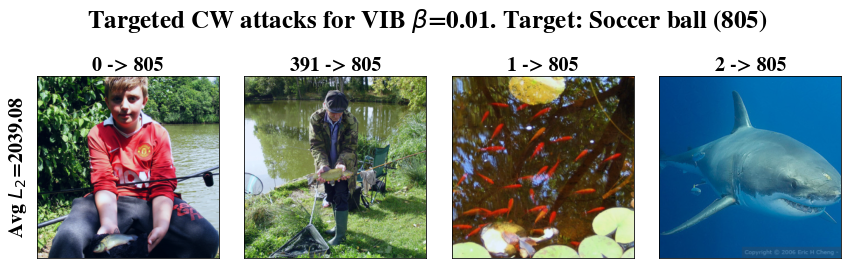

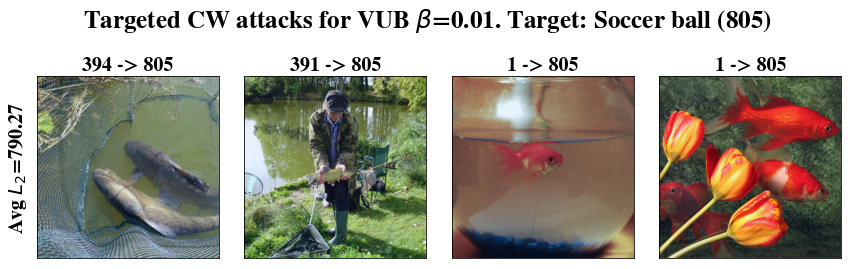

In [242]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(12,20))
i=0
for j in range(len(vib_targeted_examples[i])-1):
    cnt += 1
    plt.subplot(len(EPSILONS),len(vib_targeted_examples[0])-1,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
        plt.ylabel(r"Avg $L_{2}$=" + f"{vib_avg_dist:.2f}", fontsize=20, weight='bold')
    orig,adv,ex = vib_targeted_examples[i][j]
    plt.title("{} -> {}".format(orig, adv), fontsize=20, weight='bold')
    normalized_ex = np.transpose( (ex - ex.min()) / (ex.max() - ex.min()) , (1, 2, 0))
    plt.imshow(normalized_ex)
plt.suptitle(r"Targeted CW attacks for VIB $\beta$=0.01. Target: Soccer ball (805)", fontsize=25, y=1, weight='bold')
plt.tight_layout()
plt.show()

# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(12,20))
i=0
for j in range(len(vub_targeted_examples[i])-1):
    cnt += 1
    plt.subplot(len(EPSILONS),len(vub_targeted_examples[0])-1,cnt)
    plt.xticks([], [])
    plt.yticks([], [])
    if j == 0:
        plt.ylabel(r"Avg $L_{2}$" + f"={vub_avg_dist:.2f}", fontsize=20, weight='bold')
    orig,adv,ex = vub_targeted_examples[i][j]
    plt.title("{} -> {}".format(orig, adv), fontsize=20, weight='bold')
    normalized_ex = np.transpose( (ex - ex.min()) / (ex.max() - ex.min()) , (1, 2, 0))
    plt.imshow(normalized_ex)
# plt.set_title("Targeted attacks for VUB ß=0.01. Target: Soccer ball (805)", fontsize=14)
plt.suptitle(r"Targeted CW attacks for VUB $\beta$=0.01. Target: Soccer ball (805)", fontsize=25, y=1, weight='bold')
plt.tight_layout()
plt.show()

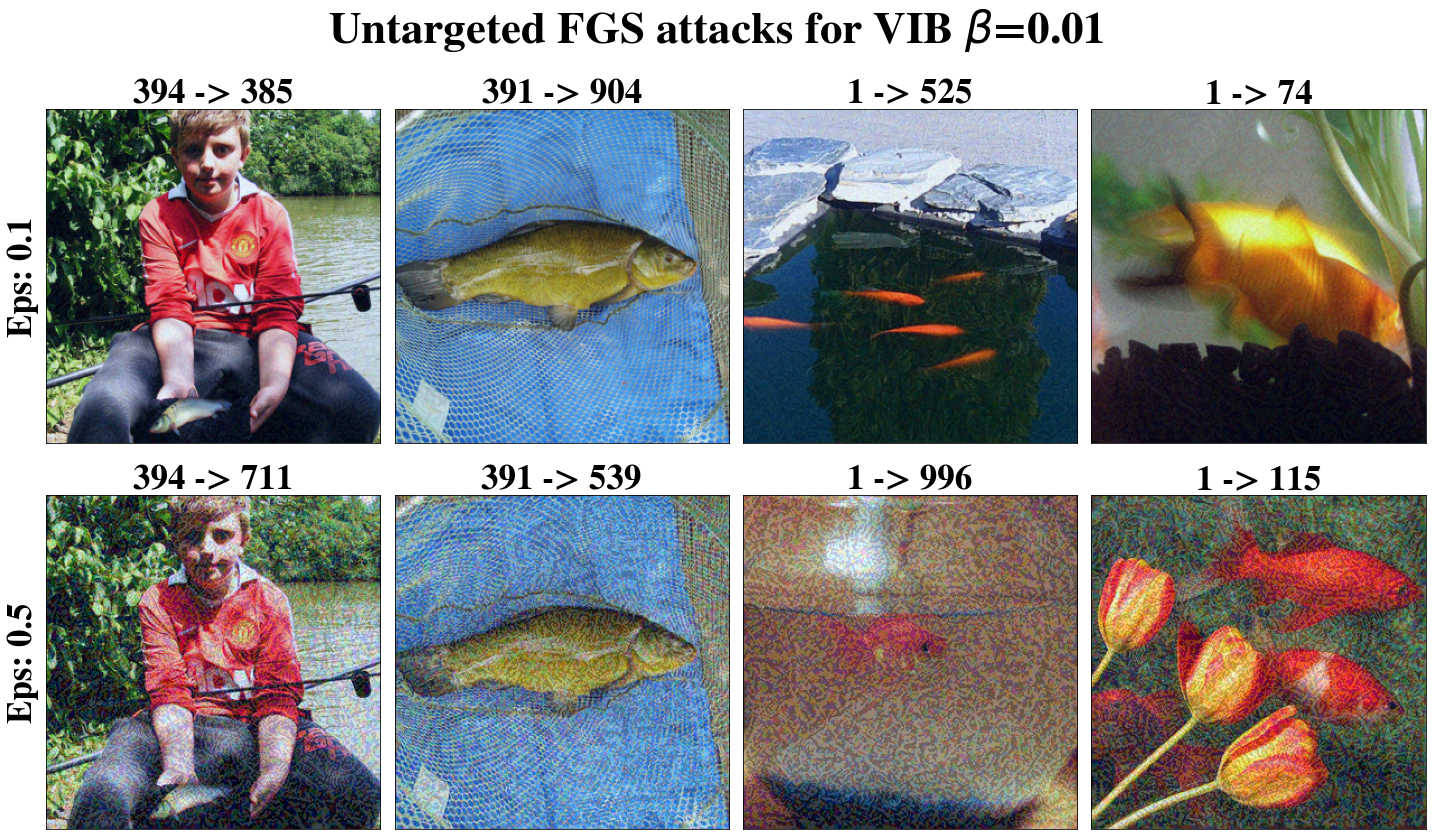

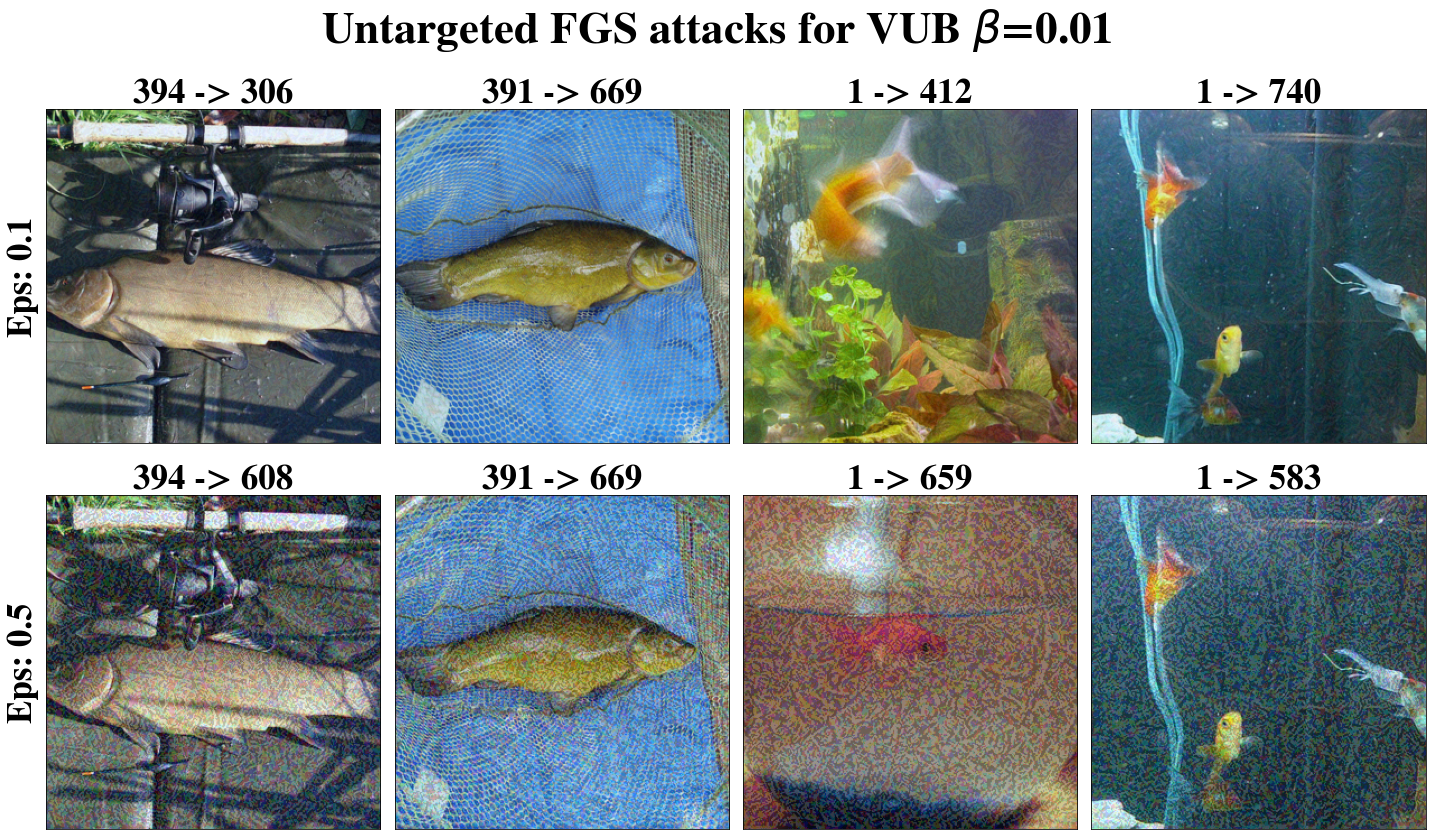

In [244]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(20,12))

vib_epsilons = [vib_epsilons[0]] + [vib_epsilons[-1]]
vib_untargeted_examples = [vib_untargeted_examples[0]] + [vib_untargeted_examples[-1]]

for i in range(2):
    for j in range(len(vib_untargeted_examples[i]) - 1):
        cnt += 1
        plt.subplot(2,len(vib_untargeted_examples[0])-1,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(vib_epsilons[i]), fontsize=35, weight='bold')
        orig,adv,ex = vib_untargeted_examples[i][j]
        plt.title("{} -> {}".format(orig, adv), fontsize=35, weight='bold')
        normalized_ex = np.transpose( (ex - ex.min()) / (ex.max() - ex.min()) , (1, 2, 0))
        plt.imshow(normalized_ex)
plt.suptitle(r"Untargeted FGS attacks for VIB $\beta$=0.01", fontsize=45, y=1, weight='bold')
plt.tight_layout()


# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(20,12))

vub_epsilons = [vub_epsilons[0]] + [vub_epsilons[-1]]
vub_untargeted_examples = [vub_untargeted_examples[0]] + [vub_untargeted_examples[-1]]

for i in range(2):
    for j in range(len(vub_untargeted_examples[i]) - 1):
        cnt += 1
        plt.subplot(2,len(vub_untargeted_examples[0])-1,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(vub_epsilons[i]), fontsize=35, weight='bold')
        orig,adv,ex = vub_untargeted_examples[i][j]
        plt.title("{} -> {}".format(orig, adv), fontsize=35, weight='bold')
        normalized_ex = np.transpose( (ex - ex.min()) / (ex.max() - ex.min()) , (1, 2, 0))
        plt.imshow(normalized_ex)
plt.suptitle(r"Untargeted FGS attacks for VUB $\beta$=0.01", fontsize=45, y=1, weight='bold')
plt.tight_layout()
plt.show()

## Info plane plots

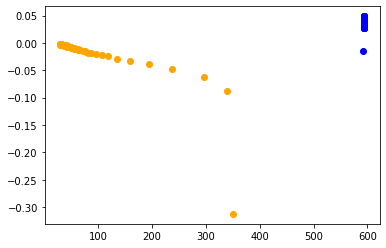

In [154]:
vub_run_id = "kibu5dm8"

vub_rate = fetch_scalar_data(vub_run_id, "charts/epoch_rate_term")
vub_distortion = fetch_scalar_data(vub_run_id, "charts/epoch_distortion_term")
vub_h_z_y = fetch_scalar_data(vub_run_id, "charts/epoch_h_z_y")
vub_loss = fetch_scalar_data(vub_run_id, "charts/epoch_classification_loss")
vub_i_z_y = vub_loss - vub_h_z_y

vib_run_id = "y312m5qj"

vib_rate = fetch_scalar_data(vib_run_id, "charts/epoch_rate_term")
vib_distortion = fetch_scalar_data(vib_run_id, "charts/epoch_distortion_term")
vib_h_z_y = fetch_scalar_data(vib_run_id, "charts/epoch_h_z_y")
vib_loss = fetch_scalar_data(vib_run_id, "charts/epoch_classification_loss")
vib_i_z_y = vib_loss - vib_h_z_y

Text(0, 0.5, '$\\propto$I(Z;Y)')

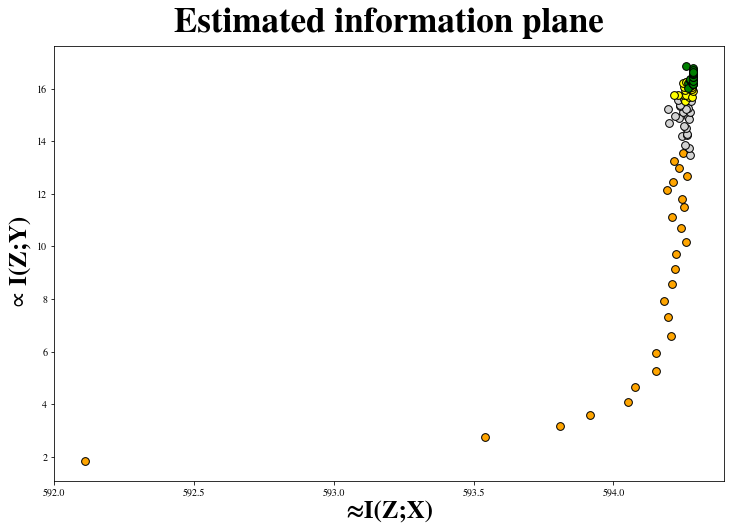

In [245]:
x = 100
fig, ax = plt.subplots(1, 1, figsize=(12,8))
_ = ax.scatter(vub_rate[0:25], 1 / vub_loss[0:25], color='orange', edgecolors='black', linewidths=1, s=60)
_ = ax.scatter(vub_rate[25:50], 1 / vub_loss[25:50], color='lightgray', edgecolors='black', linewidths=1, s=60)
_ = ax.scatter(vub_rate[50:75], 1 / vub_loss[50:75], color='yellow', edgecolors='black', linewidths=1, s=60)
_ = ax.scatter(vub_rate[75:100], 1 / vub_loss[75:100], color='green', edgecolors='black', linewidths=1, s=60)
_ = ax.set_title(r"Estimated information plane", fontsize=35, y=1.02, weight='bold')
_ = ax.set_xlabel("≈I(Z;X)", fontsize=25, weight='bold')
ax.set_ylabel(r'$\propto$' + 'I(Z;Y)', fontsize=25, weight='bold')
